In [144]:
import os
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
from configparser import ConfigParser
config = ConfigParser()
config.read("config.ini")

#api info: https://open-platform.theguardian.com/documentation/
from_date = config.get("DEFAULT", "from_date")
today = date.today()
keyword = config.get("DEFAULT", "keyword")
my_path = config.get("DEFAULT", "path") + "keyword_%s\\" %keyword
API_ENDPOINT = "http://content.guardianapis.com/search"
page_size = 200 #max=200
api_key = "f0f5a5fc-3f60-4dc4-9956-61f3b9c2c5b9"
parameter = {
    "q": keyword,
    "from-date": from_date,
    "order-by": "oldest",
    "show-fields": "none",
    "page-size": page_size,
    "currentPage": "all",
    "api-key": api_key,
    "page": 1
} 
response = requests.get(API_ENDPOINT, parameter)
data_json = response.json()
      
total_count = data_json["response"]["total"] #Anzahl der Artikel
total_pages = data_json["response"]["pages"] #Anzahl der Pages
print(total_count,"gefundene Artikel mit keyword:", keyword, "Zeitraum:",from_date,"-",today)

570 gefundene Artikel mit keyword: trudeau Zeitraum: 2018-01-01 - 2020-02-02


In [140]:
data = pd.DataFrame(index = range(total_count), columns = ["date","section","url"])
n=0
#get_data for every page, exept last page
for pages in range(total_pages-1):
    pages +=1
    parameter["page"] = pages 
    response = requests.get(API_ENDPOINT, parameter)
    data_json = response.json()
    
    for i in range(page_size):
        #time
        date = data_json["response"]["results"][i]["webPublicationDate"]
        date, time = date.split("T")
        date = datetime.strptime(date, '%Y-%m-%d')
        data.at[n+i,"date"] = date
        #section
        data.at[n+i,"section"] = data_json["response"]["results"][i]["sectionName"]
        #url
        data.at[n+i,"url"] = data_json["response"]["results"][i]["webUrl"]
    n=pages*page_size
    
#get_data for last page
parameter["page"] = total_pages #last page
response = requests.get(API_ENDPOINT, parameter)
data_json = response.json()

rest = total_count -((total_pages-1)*page_size)
for i in range(rest):
    #time
    date = data_json["response"]["results"][i]["webPublicationDate"]
    date, time = date.split("T")
    date = datetime.strptime(date, '%Y-%m-%d')
    data.at[n+i,"date"] = date
    #section
    data.at[n+i,"section"] = data_json["response"]["results"][i]["sectionName"]
    #url
    data.at[n+i,"url"] = data_json["response"]["results"][i]["webUrl"]

Im Schnitt werden 0.75 Artikel pro Tag mit dem Keyword trudeau veröffentlicht.

Die section: World news ist mit 271 Artikeln die am häufigsten vorkommende section.

      section  count  percent
0  World news  271    0.48   
1  US news     77     0.14   
2  Opinion     52     0.09   
3  Politics    30     0.05   
4  Business    26     0.05   


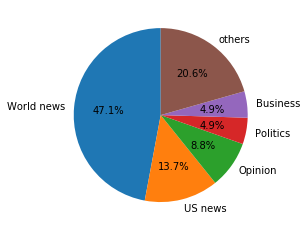

In [141]:
#dataframe mit Anzahl der veröffentichten Artikel pro Tag 
date_freq = data["date"].value_counts()
date_freq = pd.DataFrame({"date":date_freq.index, "count":date_freq.values})
date_freq = date_freq.sort_values(by="date")

#fehlende Daten hinzufügen (=Tage an denen kein Artikel erschienen ist), 
#um Verzerrung in grafischer Darstellung und Durchschnittsberechnung zu vermeinden
r = pd.date_range(start=date_freq.date.min(), end=date_freq.date.max())
date_freq_full = date_freq.set_index('date').reindex(r).fillna(0.0).rename_axis('date').reset_index()

#Durchschnitt der veröffentlichten Artikel pro Tag (Tage ohne Veröffentlichung zählen auch)
mean = round(date_freq_full["count"].mean(),2)
print("Im Schnitt werden",mean,"Artikel pro Tag mit dem Keyword",keyword,"veröffentlicht.\n")

#In welcher section werden die meisten Artikel veröffentlicht?
section_freq = data["section"].value_counts()
print("Die section:",section_freq.index[0], "ist mit",section_freq[0],"Artikeln die am häufigsten vorkommende section.\n" )
section_freq = pd.DataFrame({"section":section_freq.index, "count":section_freq.values, "percent":section_freq.values/total_count})
section_freq = section_freq.round({'percent': 2})
print(section_freq.head())

#Tortendiagramm erstellen
if len(section_freq)>5:  
    labels = section_freq["section"].head(5).values
    sizes = section_freq["percent"].head(5).values
    labels = np.append (labels, "others")
    sizes = np.append (sizes, sum(section_freq.tail(len(section_freq)-5)["percent"]))
else:
    labels = section_freq["section"].values
    sizes = section_freq["percent"].values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.show()


#99% Percentil um Ausreißer zu definieren
percentil = np.percentile(date_freq_full["count"], 99)
max_count = date_freq_full[date_freq_full["count"]>percentil]

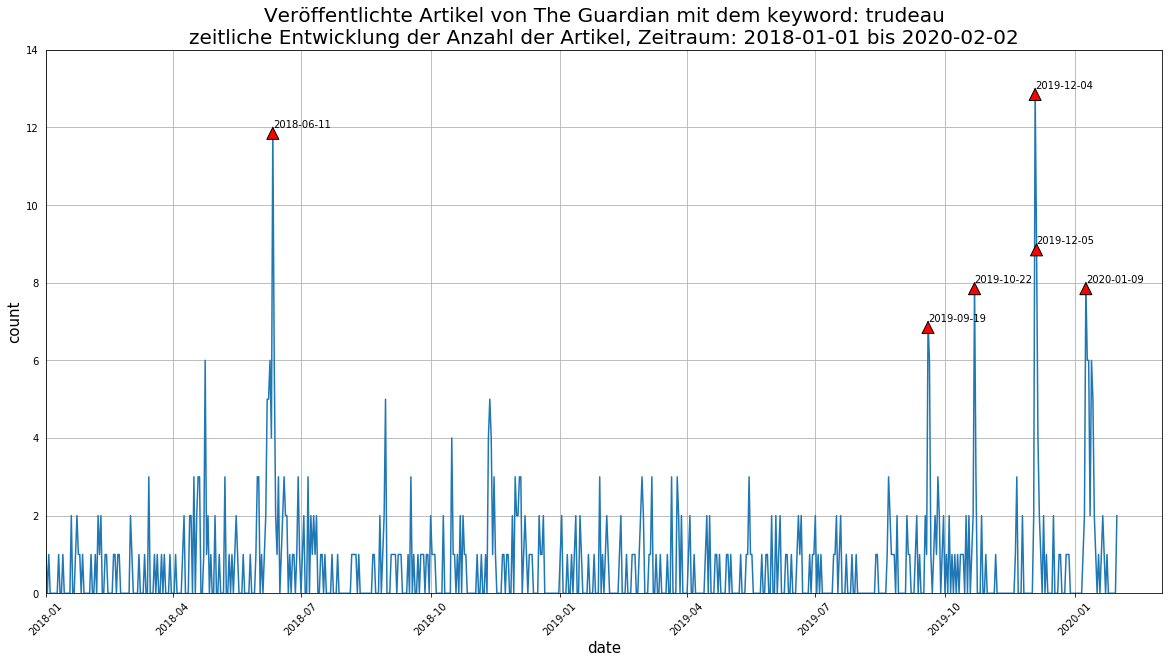

In [145]:
plt.figure(figsize=(20,10))
plt.plot_date(date_freq_full["date"], date_freq_full["count"],linestyle="solid", marker="None")
plt.title("Veröffentlichte Artikel von The Guardian mit dem keyword: "+str(keyword)+ "\nzeitliche Entwicklung der Anzahl der Artikel, Zeitraum: "+str(from_date)+" bis "+str(today),size=20)
plt.ylabel("count",size=15)
plt.xlabel("date",size=15)
plt.grid(True)
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
#plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
plt.tick_params(which='both',top=False,left=False,right=False,bottom=True) 
plt.ylim(0, date_freq["count"].max(axis=0)+1)
plt.xlim(from_date,today+timedelta(days=30))
plt.xticks(rotation=45)


for index, row in max_count.iterrows():
    date = row["date"]
    date = date.strftime("%Y-%m-%d")
    count = row["count"]
    plt.annotate(date, xy=(date, count), xytext=(date, count),
            arrowprops=dict(facecolor="red", shrink=0.01),
            )
    
try: 
    os.mkdir(my_path)  
except OSError:
       plt.savefig(my_path + "report_%s.pdf" %today)
plt.savefig(my_path + "report_%s.pdf" %today)
plt.show()

Zeige die Ursache des ungewöhnlichen Ereignisses?
--> mit Hilfe der gespeicherten URL manuell nach der Ursache suchen

In [143]:
#get url from every article from corresponding date
pd.set_option('display.max_colwidth', -1)
url = data[data["date"]==max_count["date"].iloc[0]]
url = url["url"]
url

113    https://www.theguardian.com/us-news/2018/jun/10/trump-kim-jong-un-arrive-in-singapore-for-historic-summit                         
114    https://www.theguardian.com/world/commentisfree/2018/jun/11/trump-canada-bully-trade-trudeau                                      
115    https://www.theguardian.com/us-news/2018/jun/10/justin-trudeau-donald-trump-tariffs-g7-north-korea-summit                         
116    https://www.theguardian.com/commentisfree/2018/jun/11/merkel-macron-g7-photos-social-media-trump                                  
117    https://www.theguardian.com/world/2018/jun/11/qa-how-damaging-was-donald-trump-g7-blow-up                                         
118    https://www.theguardian.com/business/live/2018/jun/11/markets-g7-debacle-free-trade-trump-uk-growth-business-live                 
119    https://www.theguardian.com/commentisfree/2018/jun/11/trump-canada-relationship-us                                                
120    https://www.theguardian.com